In [1]:
%%capture cap
!pip install ipywidgets
!pip install autogluon scikit-learn==1.5.2 
!apt-get install -y graphviz graphviz-dev && pip install pydot
!pip install pygraphviz

In [2]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
# pd.options.mode.copy_on_write = True
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [3]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
                  ignore_index=True)

X_test = pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

train.shape, test.shape

((517754, 13), (172585, 12))

In [4]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [5]:
def plot_heatmap(data, cat_features: list, title: str):
    df = data.copy()
    for c in cat_features:
        df[c], _ = pd.factorize(df[c])
    plt.figure(figsize=(18, 7))
    sns.heatmap(df.corr('spearman'), mask=np.triu(df.corr('spearman')), annot=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

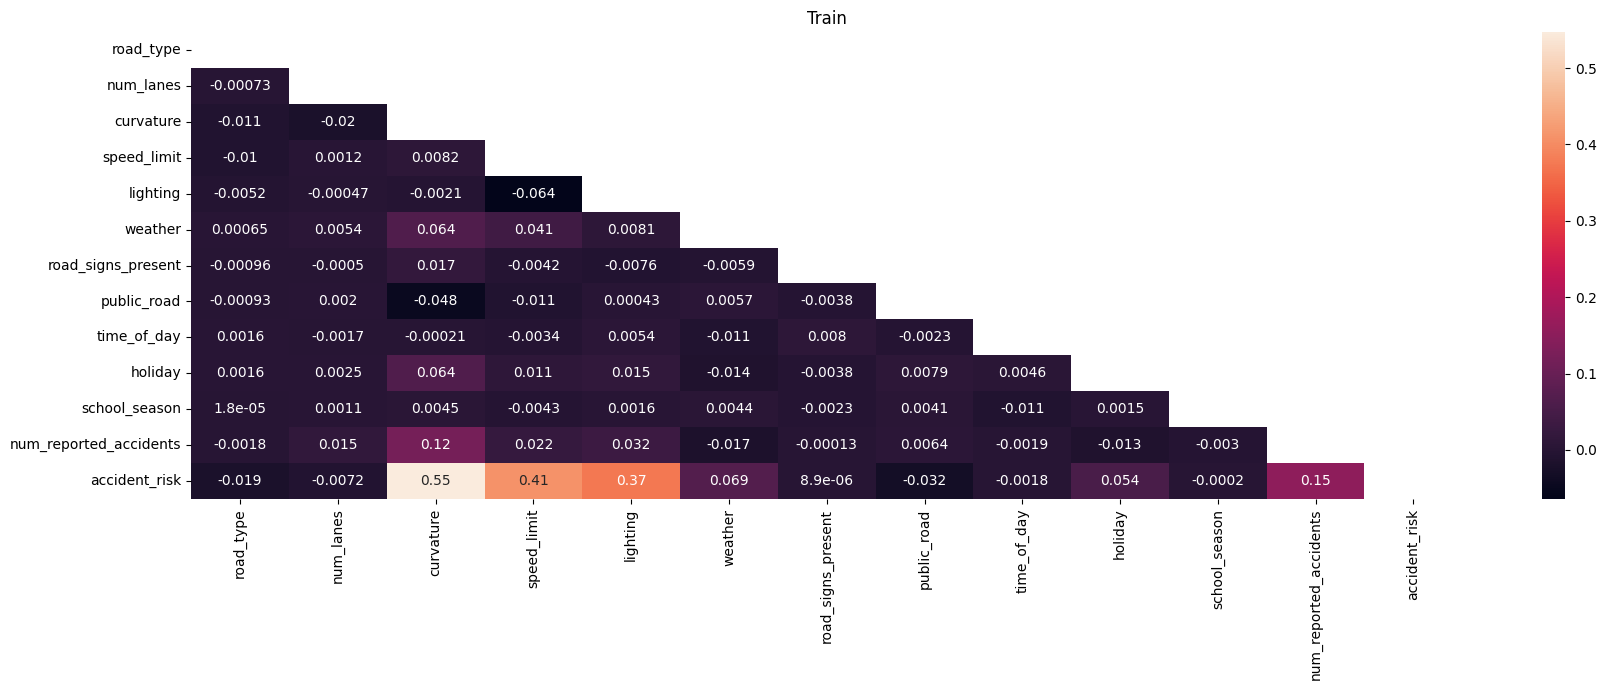

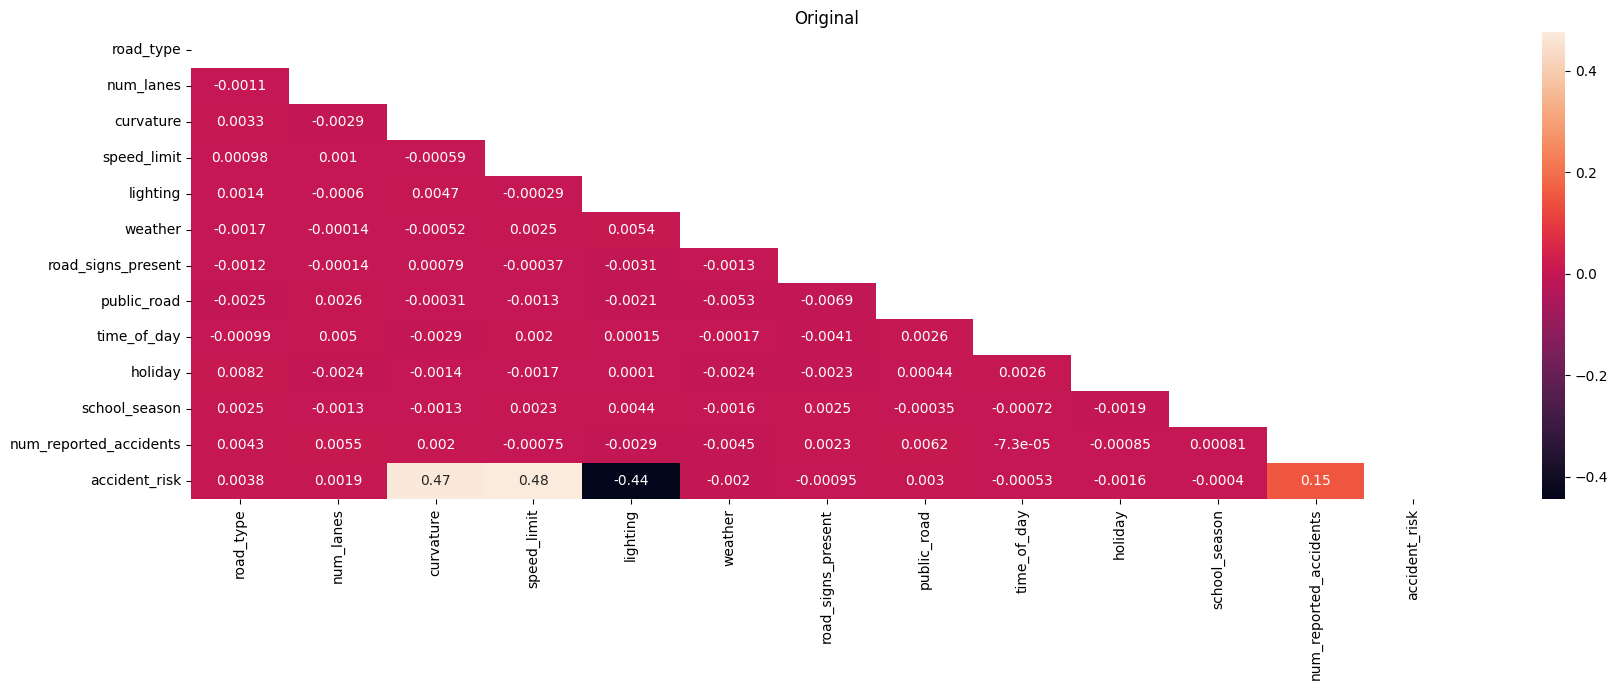

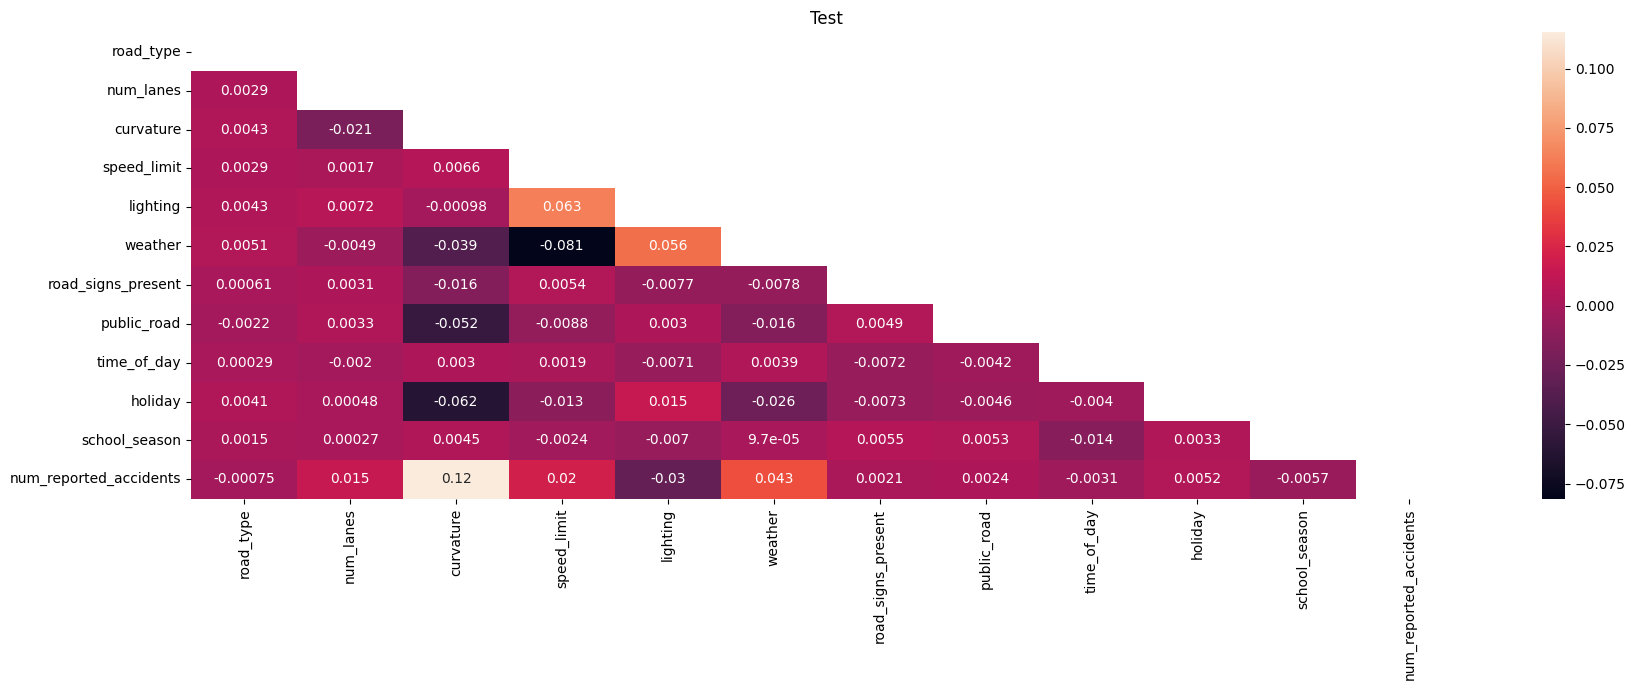

In [6]:
plot_heatmap(train, CATS, "Train")
plot_heatmap(orig, CATS, "Original")
plot_heatmap(test, CATS, "Test")

In [7]:
## -- CREATE FEATURES -- ##
def create_features(train_df, test_df, orig_df):
    train = train_df.copy()
    test  = test_df.copy()
    orig  = orig_df.copy()

    ## -- meta feature --
    BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
    for df in [train, test, orig]:
        base_risk = (
            0.3 * df["curvature"] +
            0.2 * (df["lighting"] == "night").astype(int) +
            0.1 * (df["weather"] != "clear").astype(int) +
            0.2 * (df["speed_limit"] >= 60).astype(int) +
            0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
                )
        df['meta'] = base_risk

        df['BINARY'] = 0
        for i in range(len(BINARY_COLS)):
            df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)

    print(f"✅ 'meta' feature created!")
    print(f"✅ 'BINARY' feature created!")

    DIGITS = []
    for c in ['curvature', 'speed_limit']: # only features with > 1 digits
        for i in range(-3, 3):
            n = f"{c}_{i}"
            train[n] = ((train[c] * 10**i) % 10).astype("int8")
            test[n]  = ((test[c]  * 10**i) % 10).astype("int8")
            orig[n]  = ((orig[c]  * 10**i) % 10).astype("int8")
            if train[n].nunique()==1:
                train = train.drop([n], axis=1)
                test  = test.drop([n],  axis=1)
                orig  = orig.drop([n],  axis=1)
            else:
                DIGITS.append(n)
    print(f"✅  Digits extract features: {len(DIGITS)}")
    for col in DIGITS:
        print(f"{col}: {train[col].nunique()} unique values")

    ## -- FEATURE 1: Use original as features
    # BINARY_COLS.remove('holiday')
    FEAT = [c for c in test.columns if c not in BINARY_COLS] # Exclude binned features
    print(f"Merging {len(FEAT)} features: ", end="")
    STATS = ['mean','count'] # ,'nunique','max','min',
    for c in FEAT:
        print(f"{c}, ", end="")
        tmp = orig.groupby(c)[TARGET].agg(STATS)
        tmp.columns = [f"OTE_{c}_{s.upper()}" for s in STATS]
        train = train.merge(tmp, on=c, how='left')
        test  = test.merge(tmp,  on=c, how='left')
    print()

    BINS = []
    print(f"\nCreating bins... ", end="")
    for c in ['curvature', 'meta']: # <- add feature 1 after the other
        for b in [4, 10]:
            print(f"{c}_{b}, ", end="")
            b_n = f'{c}_bin_{b}'
            # Fit on train data and transform both train and test
            bins = np.linspace(train[c].min(), train[c].max(), b+1)
            train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
            test[b_n]  = pd.cut(test[c],  include_lowest=True, labels=False, bins=bins)
            BINS.append(b_n)
    print()
    print(f"✅ {len(BINS)} binned features created!")

    ## -- Factorize using combined data to ensure consistent mapping --
    BOOLS = train.select_dtypes(include=bool).columns
    for c in CATS:
        if c not in BOOLS:
            combined = pd.concat([train[c], test[c]], axis=0)
            combined = pd.factorize(combined)[0]
            train[c] = combined[:len(train)].astype("int8")
            test[c]  = combined[-len(test):].astype("int8")

    ## -- Polynomials --
    for df in [train, test]:
        df['curvature_sqrt'] = np.sqrt(df['curvature']) # Square-root
        df['curvature_squared'] = df['curvature'] ** 2 # Squared
        df['curvature_cubed'] = df['curvature'] ** 3 # Cubed
        df['curve-+-speed-+-light'] = df[['curvature', 'speed_limit', 'lighting']].sum(axis=1)
    print(f"✅ Polynomial features created!")

    ## -- Pairwise combinations --
    TE = []
    for n in [2]:
        for cols in tqdm(list(combinations(FEATURES+BINS+DIGITS+['BINARY'], n)), desc="Creating Pairwise"):
            n = '-|-'.join(sorted(cols))
            train[n] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
            test[n] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)
            train[n] = train[n].astype('category')
            
            cat = train[n].cat
            train[n] = train[n].cat.codes
            
            test[n] = pd.Categorical(test[n], categories=cat.categories).codes
            TE.append(n)

    ## -- Triplewise combinations --
    TOP_PREDICTORS = ['curvature','lighting','speed_limit','weather','num_reported_accidents']
    for n in [3]:
        for cols in tqdm(list(combinations(TOP_PREDICTORS, n)), desc="Creating Triplewise"):
            nm = '-|-'.join(sorted(cols))
            train[nm] = train[cols[0]].astype(str) + '_' + \
                        train[cols[1]].astype(str) + '_' + \
                        train[cols[2]].astype(str)
            test[nm]  = test[cols[0]].astype(str) + '_' + \
                        test[cols[1]].astype(str) + '_' + \
                        test[cols[2]].astype(str)
            
            train[nm] = train[nm].astype('category')
            cat = train[nm].cat
            train[nm] = train[nm].cat.codes
            test[nm] = pd.Categorical(test[nm], categories=cat.categories).codes
            TE.append(nm)

    print(f"✅ Interations (TE) created: {len(TE)}")
    print(f"✅ Binned features (BINS): {len(BINS)}")
    print(f"{COLOR}{'='*50}")
    print(f"ℹ️ Feature Engineering Complete!")
    print(f"ℹ️ Total features: {len(test.columns)}")
    print(f"{'='*50}")

    return train, test#, valid

In [8]:
train, test = create_features(train, test, orig)

✅ 'meta' feature created!
✅ 'BINARY' feature created!
✅  Digits extract features: 5
curvature_0: 2 unique values
curvature_1: 10 unique values
curvature_2: 10 unique values
speed_limit_-1: 5 unique values
speed_limit_0: 2 unique values
Merging 15 features: road_type, num_lanes, curvature, speed_limit, lighting, weather, time_of_day, num_reported_accidents, meta, BINARY, curvature_0, curvature_1, curvature_2, speed_limit_-1, speed_limit_0, 

Creating bins... curvature_4, curvature_10, meta_4, meta_10, 
✅ 4 binned features created!
✅ Polynomial features created!


Creating Pairwise:   0%|          | 0/231 [00:00<?, ?it/s]

Creating Triplewise:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Interations (TE) created: 241
✅ Binned features (BINS): 4
ℹ️ Feature Engineering Complete!
ℹ️ Total features: 298


In [9]:
train.shape, test.shape

((517754, 299), (172585, 298))

In [10]:
display(train.head())
# train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,BINARY,curvature_0,curvature_1,curvature_2,speed_limit_-1,speed_limit_0,OTE_road_type_MEAN,OTE_road_type_COUNT,OTE_num_lanes_MEAN,OTE_num_lanes_COUNT,OTE_curvature_MEAN,OTE_curvature_COUNT,OTE_speed_limit_MEAN,OTE_speed_limit_COUNT,OTE_lighting_MEAN,OTE_lighting_COUNT,OTE_weather_MEAN,OTE_weather_COUNT,OTE_time_of_day_MEAN,OTE_time_of_day_COUNT,OTE_num_reported_accidents_MEAN,OTE_num_reported_accidents_COUNT,OTE_meta_MEAN,OTE_meta_COUNT,OTE_BINARY_MEAN,OTE_BINARY_COUNT,OTE_curvature_0_MEAN,OTE_curvature_0_COUNT,OTE_curvature_1_MEAN,OTE_curvature_1_COUNT,OTE_curvature_2_MEAN,OTE_curvature_2_COUNT,OTE_speed_limit_-1_MEAN,OTE_speed_limit_-1_COUNT,OTE_speed_limit_0_MEAN,OTE_speed_limit_0_COUNT,curvature_bin_4,curvature_bin_10,meta_bin_4,meta_bin_10,curvature_sqrt,curvature_squared,curvature_cubed,curve-+-speed-+-light,curvature-|-num_lanes,num_lanes-|-speed_limit,num_lanes-|-num_reported_accidents,num_lanes-|-road_type,lighting-|-num_lanes,num_lanes-|-weather,num_lanes-|-road_signs_present,num_lanes-|-public_road,num_lanes-|-time_of_day,holiday-|-num_lanes,num_lanes-|-school_season,curvature_bin_4-|-num_lanes,curvature_bin_10-|-num_lanes,meta_bin_4-|-num_lanes,meta_bin_10-|-num_lanes,curvature_0-|-num_lanes,curvature_1-|-num_lanes,curvature_2-|-num_lanes,num_lanes-|-speed_limit_-1,num_lanes-|-speed_limit_0,BINARY-|-num_lanes,curvature-|-speed_limit,curvature-|-num_reported_accidents,curvature-|-road_type,curvature-|-lighting,curvature-|-weather,curvature-|-road_signs_present,curvature-|-public_road,curvature-|-time_of_day,curvature-|-holiday,curvature-|-school_season,curvature-|-curvature_bin_4,curvature-|-curvature_bin_10,curvature-|-meta_bin_4,curvature-|-meta_bin_10,curvature-|-curvature_0,curvature-|-curvature_1,curvature-|-curvature_2,curvature-|-speed_limit_-1,curvature-|-speed_limit_0,BINARY-|-curvature,num_reported_accidents-|-speed_limit,road_type-|-speed_limit,lighting-|-speed_limit,speed_limit-|-weather,road_signs_present-|-speed_limit,public_road-|-speed_limit,speed_limit-|-time_of_day,holiday-|-speed_limit,school_season-|-speed_limit,curvature_bin_4-|-speed_limit,curvature_bin_10-|-speed_limit,meta_bin_4-|-speed_limit,meta_bin_10-|-speed_limit,curvature_0-|-speed_limit,curvature_1-|-speed_limit,curvature_2-|-speed_limit,speed_limit-|-speed_limit_-1,speed_limit-|-speed_limit_0,BINARY-|-speed_limit,num_reported_accidents-|-road_type,lighting-|-num_reported_accidents,num_reported_accidents-|-weather,num_reported_accidents-|-road_signs_present,num_reported_accidents-|-public_road,num_reported_accidents-|-time_of_day,holiday-|-num_reported_accidents,num_reported_accidents-|-school_season,curvature_bin_4-|-num_reported_accidents,curvature_bin_10-|-num_reported_accidents,meta_bin_4-|-num_reported_accidents,meta_bin_10-|-num_reported_accidents,curvature_0-|-num_reported_accidents,curvature_1-|-num_reported_accidents,curvature_2-|-num_reported_accidents,num_reported_accidents-|-speed_limit_-1,num_reported_accidents-|-speed_limit_0,BINARY-|-num_reported_accidents,lighting-|-road_type,road_type-|-weather,road_signs_present-|-road_type,public_road-|-road_type,road_type-|-time_of_day,holiday-|-road_type,road_type-|-school_season,curvature_bin_4-|-road_type,curvature_bin_10-|-road_type,meta_bin_4-|-road_type,meta_bin_10-|-road_type,curvature_0-|-road_type,curvature_1-|-road_type,curvature_2-|-road_type,road_type-|-speed_limit_-1,road_type-|-speed_limit_0,BINARY-|-road_type,lighting-|-weather,lighting-|-road_signs_present,lighting-|-public_road,lighting-|-time_of_day,holiday-|-lighting,lighting-|-school_season,curvature_bin_4-|-lighting,curvature_bin_10-|-lighting,lighting-|-meta_bin_4,lighting-|-meta_bin_10,curvature_0-|-lighting,curvature_1-|-lighting,curvature_2-|-lighting,lighting-|-speed_limit_-1,lighting-|-speed_limit_0,BINARY-|-lighting,road_signs_present-|-weat

In [11]:
display(test.head())
# test.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,meta,BINARY,curvature_0,curvature_1,curvature_2,speed_limit_-1,speed_limit_0,OTE_road_type_MEAN,OTE_road_type_COUNT,OTE_num_lanes_MEAN,OTE_num_lanes_COUNT,OTE_curvature_MEAN,OTE_curvature_COUNT,OTE_speed_limit_MEAN,OTE_speed_limit_COUNT,OTE_lighting_MEAN,OTE_lighting_COUNT,OTE_weather_MEAN,OTE_weather_COUNT,OTE_time_of_day_MEAN,OTE_time_of_day_COUNT,OTE_num_reported_accidents_MEAN,OTE_num_reported_accidents_COUNT,OTE_meta_MEAN,OTE_meta_COUNT,OTE_BINARY_MEAN,OTE_BINARY_COUNT,OTE_curvature_0_MEAN,OTE_curvature_0_COUNT,OTE_curvature_1_MEAN,OTE_curvature_1_COUNT,OTE_curvature_2_MEAN,OTE_curvature_2_COUNT,OTE_speed_limit_-1_MEAN,OTE_speed_limit_-1_COUNT,OTE_speed_limit_0_MEAN,OTE_speed_limit_0_COUNT,curvature_bin_4,curvature_bin_10,meta_bin_4,meta_bin_10,curvature_sqrt,curvature_squared,curvature_cubed,curve-+-speed-+-light,curvature-|-num_lanes,num_lanes-|-speed_limit,num_lanes-|-num_reported_accidents,num_lanes-|-road_type,lighting-|-num_lanes,num_lanes-|-weather,num_lanes-|-road_signs_present,num_lanes-|-public_road,num_lanes-|-time_of_day,holiday-|-num_lanes,num_lanes-|-school_season,curvature_bin_4-|-num_lanes,curvature_bin_10-|-num_lanes,meta_bin_4-|-num_lanes,meta_bin_10-|-num_lanes,curvature_0-|-num_lanes,curvature_1-|-num_lanes,curvature_2-|-num_lanes,num_lanes-|-speed_limit_-1,num_lanes-|-speed_limit_0,BINARY-|-num_lanes,curvature-|-speed_limit,curvature-|-num_reported_accidents,curvature-|-road_type,curvature-|-lighting,curvature-|-weather,curvature-|-road_signs_present,curvature-|-public_road,curvature-|-time_of_day,curvature-|-holiday,curvature-|-school_season,curvature-|-curvature_bin_4,curvature-|-curvature_bin_10,curvature-|-meta_bin_4,curvature-|-meta_bin_10,curvature-|-curvature_0,curvature-|-curvature_1,curvature-|-curvature_2,curvature-|-speed_limit_-1,curvature-|-speed_limit_0,BINARY-|-curvature,num_reported_accidents-|-speed_limit,road_type-|-speed_limit,lighting-|-speed_limit,speed_limit-|-weather,road_signs_present-|-speed_limit,public_road-|-speed_limit,speed_limit-|-time_of_day,holiday-|-speed_limit,school_season-|-speed_limit,curvature_bin_4-|-speed_limit,curvature_bin_10-|-speed_limit,meta_bin_4-|-speed_limit,meta_bin_10-|-speed_limit,curvature_0-|-speed_limit,curvature_1-|-speed_limit,curvature_2-|-speed_limit,speed_limit-|-speed_limit_-1,speed_limit-|-speed_limit_0,BINARY-|-speed_limit,num_reported_accidents-|-road_type,lighting-|-num_reported_accidents,num_reported_accidents-|-weather,num_reported_accidents-|-road_signs_present,num_reported_accidents-|-public_road,num_reported_accidents-|-time_of_day,holiday-|-num_reported_accidents,num_reported_accidents-|-school_season,curvature_bin_4-|-num_reported_accidents,curvature_bin_10-|-num_reported_accidents,meta_bin_4-|-num_reported_accidents,meta_bin_10-|-num_reported_accidents,curvature_0-|-num_reported_accidents,curvature_1-|-num_reported_accidents,curvature_2-|-num_reported_accidents,num_reported_accidents-|-speed_limit_-1,num_reported_accidents-|-speed_limit_0,BINARY-|-num_reported_accidents,lighting-|-road_type,road_type-|-weather,road_signs_present-|-road_type,public_road-|-road_type,road_type-|-time_of_day,holiday-|-road_type,road_type-|-school_season,curvature_bin_4-|-road_type,curvature_bin_10-|-road_type,meta_bin_4-|-road_type,meta_bin_10-|-road_type,curvature_0-|-road_type,curvature_1-|-road_type,curvature_2-|-road_type,road_type-|-speed_limit_-1,road_type-|-speed_limit_0,BINARY-|-road_type,lighting-|-weather,lighting-|-road_signs_present,lighting-|-public_road,lighting-|-time_of_day,holiday-|-lighting,lighting-|-school_season,curvature_bin_4-|-lighting,curvature_bin_10-|-lighting,lighting-|-meta_bin_4,lighting-|-meta_bin_10,curvature_0-|-lighting,curvature_1-|-lighting,curvature_2-|-lighting,lighting-|-speed_limit_-1,lighting-|-speed_limit_0,BINARY-|-lighting,road_signs_present-|-weather,public_roa

In [12]:
# !rm -r /kaggle/working/AG_accident_models

In [13]:
from autogluon.tabular import TabularPredictor

## -- RUN 1: Use train data -- 
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_accident_models",
).fit(
                   train_data = train,
                      presets = 'best',
                num_bag_folds = 10,
             dynamic_stacking = False,
                   # auto_stack = False,
             num_stack_levels = 1,
                 # num_bag_sets = 2,
                   time_limit = 3600*11,
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
         # included_model_types = ['RF', 'XT', 'FASTAI'],
                     # num_gpus = torch.cuda.device_count(),
                  # ag_args_fit = {'num_cpus': os.cpu_count() - 1},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.46 GB / 31.35 GB (94.0%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 39600s
AutoGluon will save models to "/kaggle/working/AG_accident_models"
Train Data Rows:    517754
Train Data Columns: 298
Label Column:       accident_risk
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                

In [14]:
## -- Get Summary --
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}") 

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 16
-> Best model   : WeightedEnsemble_L3


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.055845,root_mean_squared_error,466.497750,37449.823066,0.011171,1.827875,3,True,16
1,WeightedEnsemble_L2,-0.055955,root_mean_squared_error,246.514452,15515.421193,0.013721,0.775316,2,True,11
2,LightGBM_BAG_L2,-0.055958,root_mean_squared_error,370.996752,26720.249249,7.189637,624.136816,2,True,13
3,RandomForestMSE_BAG_L2,-0.055965,root_mean_squared_error,459.296942,36823.858375,95.489827,10727.745942,2,True,14
4,CatBoost_BAG_L1,-0.055991,root_mean_squared_error,2.395399,4232.437251,2.395399,4232.437251,1,True,4
5,LightGBM_BAG_L1,-0.056010,root_mean_squared_error,32.419884,1617.203224,32.419884,1617.203224,1,True,2
6,LightGBMXT_BAG_L1,-0.056017,root_mean_squared_error,87.758067,2925.705953,87.758067,2925.705953,1,True,1
7,XGBoost_BAG_L1,-0.056024,root_mean_squared_error,21.976830,706.725682,21.976830,706.725682,1,True,7
8,LightGBMXT_BAG_L2,-0.056030,root_mean_squared_error,383.680447,27298.967577,19.873333,1202.855144,2,True,12
9,CatBoost_BAG_L2,-0.056069,root_mean_squared_error,365.181408,26481.480927,1.374294,385.368494,2,True,15


In [15]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [16]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [17]:
## -- Create folder directory to save predictions --
NAME_EXT = "_FE298-CPU"
FOLDER   = "AG_accident_predictions"
!mkdir /kaggle/working/{FOLDER}{NAME_EXT}

In [18]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)

## -- Make Submission --
submit = pd.read_csv(PATH+"sample_submission.csv")

SUBMIT_FILE = f'submit_AG{NAME_EXT}.csv'
submit[TARGET] = pred_df.values
submit.to_csv(SUBMIT_FILE, index=False)
print(f"---> Submission file saved as: {SUBMIT_FILE} !")
submit.head(10)

2025-10-21 03:10:22,725	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-10-21 03:10:23,726	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-10-21 03:10:23,730	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


---> Submission file saved as: submit_AG_FE298-CPU.csv !


,id,accident_risk
0,517754,0.296809
1,517755,0.122675
2,517756,0.180174
3,517757,0.308991
4,517758,0.399161
5,517759,0.456496
6,517760,0.261605
7,517761,0.196881
8,517762,0.371728
9,517763,0.321054


In [19]:
## -- Generate predictions for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Save TEST predictions of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

SAVE_PRED = f"/kaggle/working/{FOLDER}{NAME_EXT}/pred_ag{NAME_EXT}.parquet"
final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(SAVE_PRED, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/16 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE298-CPU,LightGBMBAGL1_FE298-CPU,RandomForestMSEBAGL1_FE298-CPU,CatBoostBAGL1_FE298-CPU,ExtraTreesMSEBAGL1_FE298-CPU,NeuralNetFastAIBAGL1_FE298-CPU,XGBoostBAGL1_FE298-CPU,NeuralNetTorchBAGL1_FE298-CPU,LightGBMLargeBAGL1_FE298-CPU,CatBoostr177BAGL1_FE298-CPU,WeightedEnsembleL2_FE298-CPU,LightGBMXTBAGL2_FE298-CPU,LightGBMBAGL2_FE298-CPU,RandomForestMSEBAGL2_FE298-CPU,CatBoostBAGL2_FE298-CPU,WeightedEnsembleL3_FE298-CPU
0,0.293489,0.294104,0.313616,0.293007,0.309266,0.294253,0.294535,0.303835,0.297117,0.301554,0.295233,0.296558,0.294622,0.299885,0.296535,0.296809
1,0.122788,0.122966,0.120795,0.122078,0.119302,0.122920,0.122978,0.140794,0.131935,0.143436,0.122368,0.122910,0.123340,0.122517,0.121231,0.122675
2,0.180107,0.178879,0.174484,0.178752,0.174057,0.183390,0.182110,0.201601,0.189432,0.198909,0.179925,0.179441,0.180679,0.179871,0.182232,0.180174
3,0.304776,0.308349,0.320782,0.307096,0.319560,0.309431,0.311320,0.328024,0.322277,0.374128,0.309439,0.314731,0.310231,0.308995,0.314714,0.308991
4,0.393294,0.392740,0.409914,0.393867,0.404728,0.393317,0.392192,0.380698,0.396765,0.359202,0.394193,0.399295,0.396567,0.404678,0.400399,0.399161


In [20]:
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                     model = model,
                                train_data = train
                            )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v
    
SAVE_OOF = f"/kaggle/working/{FOLDER}{NAME_EXT}/oof_ag{NAME_EXT}.parquet"
final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(SAVE_OOF, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/16 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE298-CPU,LightGBMBAGL1_FE298-CPU,RandomForestMSEBAGL1_FE298-CPU,CatBoostBAGL1_FE298-CPU,ExtraTreesMSEBAGL1_FE298-CPU,NeuralNetFastAIBAGL1_FE298-CPU,XGBoostBAGL1_FE298-CPU,NeuralNetTorchBAGL1_FE298-CPU,LightGBMLargeBAGL1_FE298-CPU,CatBoostr177BAGL1_FE298-CPU,WeightedEnsembleL2_FE298-CPU,LightGBMXTBAGL2_FE298-CPU,LightGBMBAGL2_FE298-CPU,RandomForestMSEBAGL2_FE298-CPU,CatBoostBAGL2_FE298-CPU,WeightedEnsembleL3_FE298-CPU
0,0.125090,0.126018,0.129459,0.126967,0.128773,0.132395,0.128826,0.153085,0.129784,0.130536,0.128113,0.127241,0.129216,0.127640,0.126770,0.128124
1,0.323386,0.316682,0.317579,0.325921,0.321671,0.321675,0.320658,0.337096,0.319464,0.313799,0.321895,0.320884,0.320105,0.324229,0.321295,0.322750
2,0.393225,0.391299,0.389240,0.387258,0.386554,0.390399,0.391816,0.388319,0.390201,0.381141,0.389871,0.391873,0.389180,0.387889,0.397551,0.388734
3,0.128809,0.129183,0.133744,0.127780,0.132141,0.132348,0.129646,0.146253,0.141666,0.150867,0.129695,0.130261,0.129637,0.136886,0.130928,0.133039
4,0.471381,0.469001,0.463035,0.470076,0.462694,0.473447,0.470187,0.460359,0.467342,0.458975,0.469961,0.469821,0.470275,0.470533,0.470111,0.470546


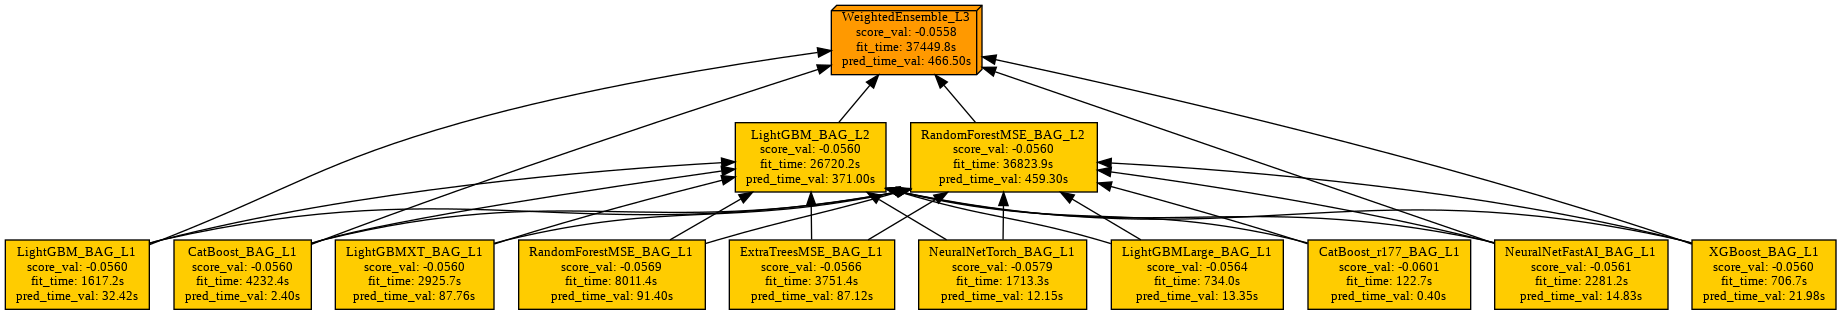

In [21]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_accident_models/ensemble_model.png'))

In [22]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
!zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

  adding: kaggle/working/AG_accident_predictions_FE298-CPU/ (stored 0%)
  adding: kaggle/working/AG_accident_predictions_FE298-CPU/oof_ag_FE298-CPU.parquet (deflated 10%)
  adding: kaggle/working/AG_accident_predictions_FE298-CPU/pred_ag_FE298-CPU.parquet (deflated 9%)


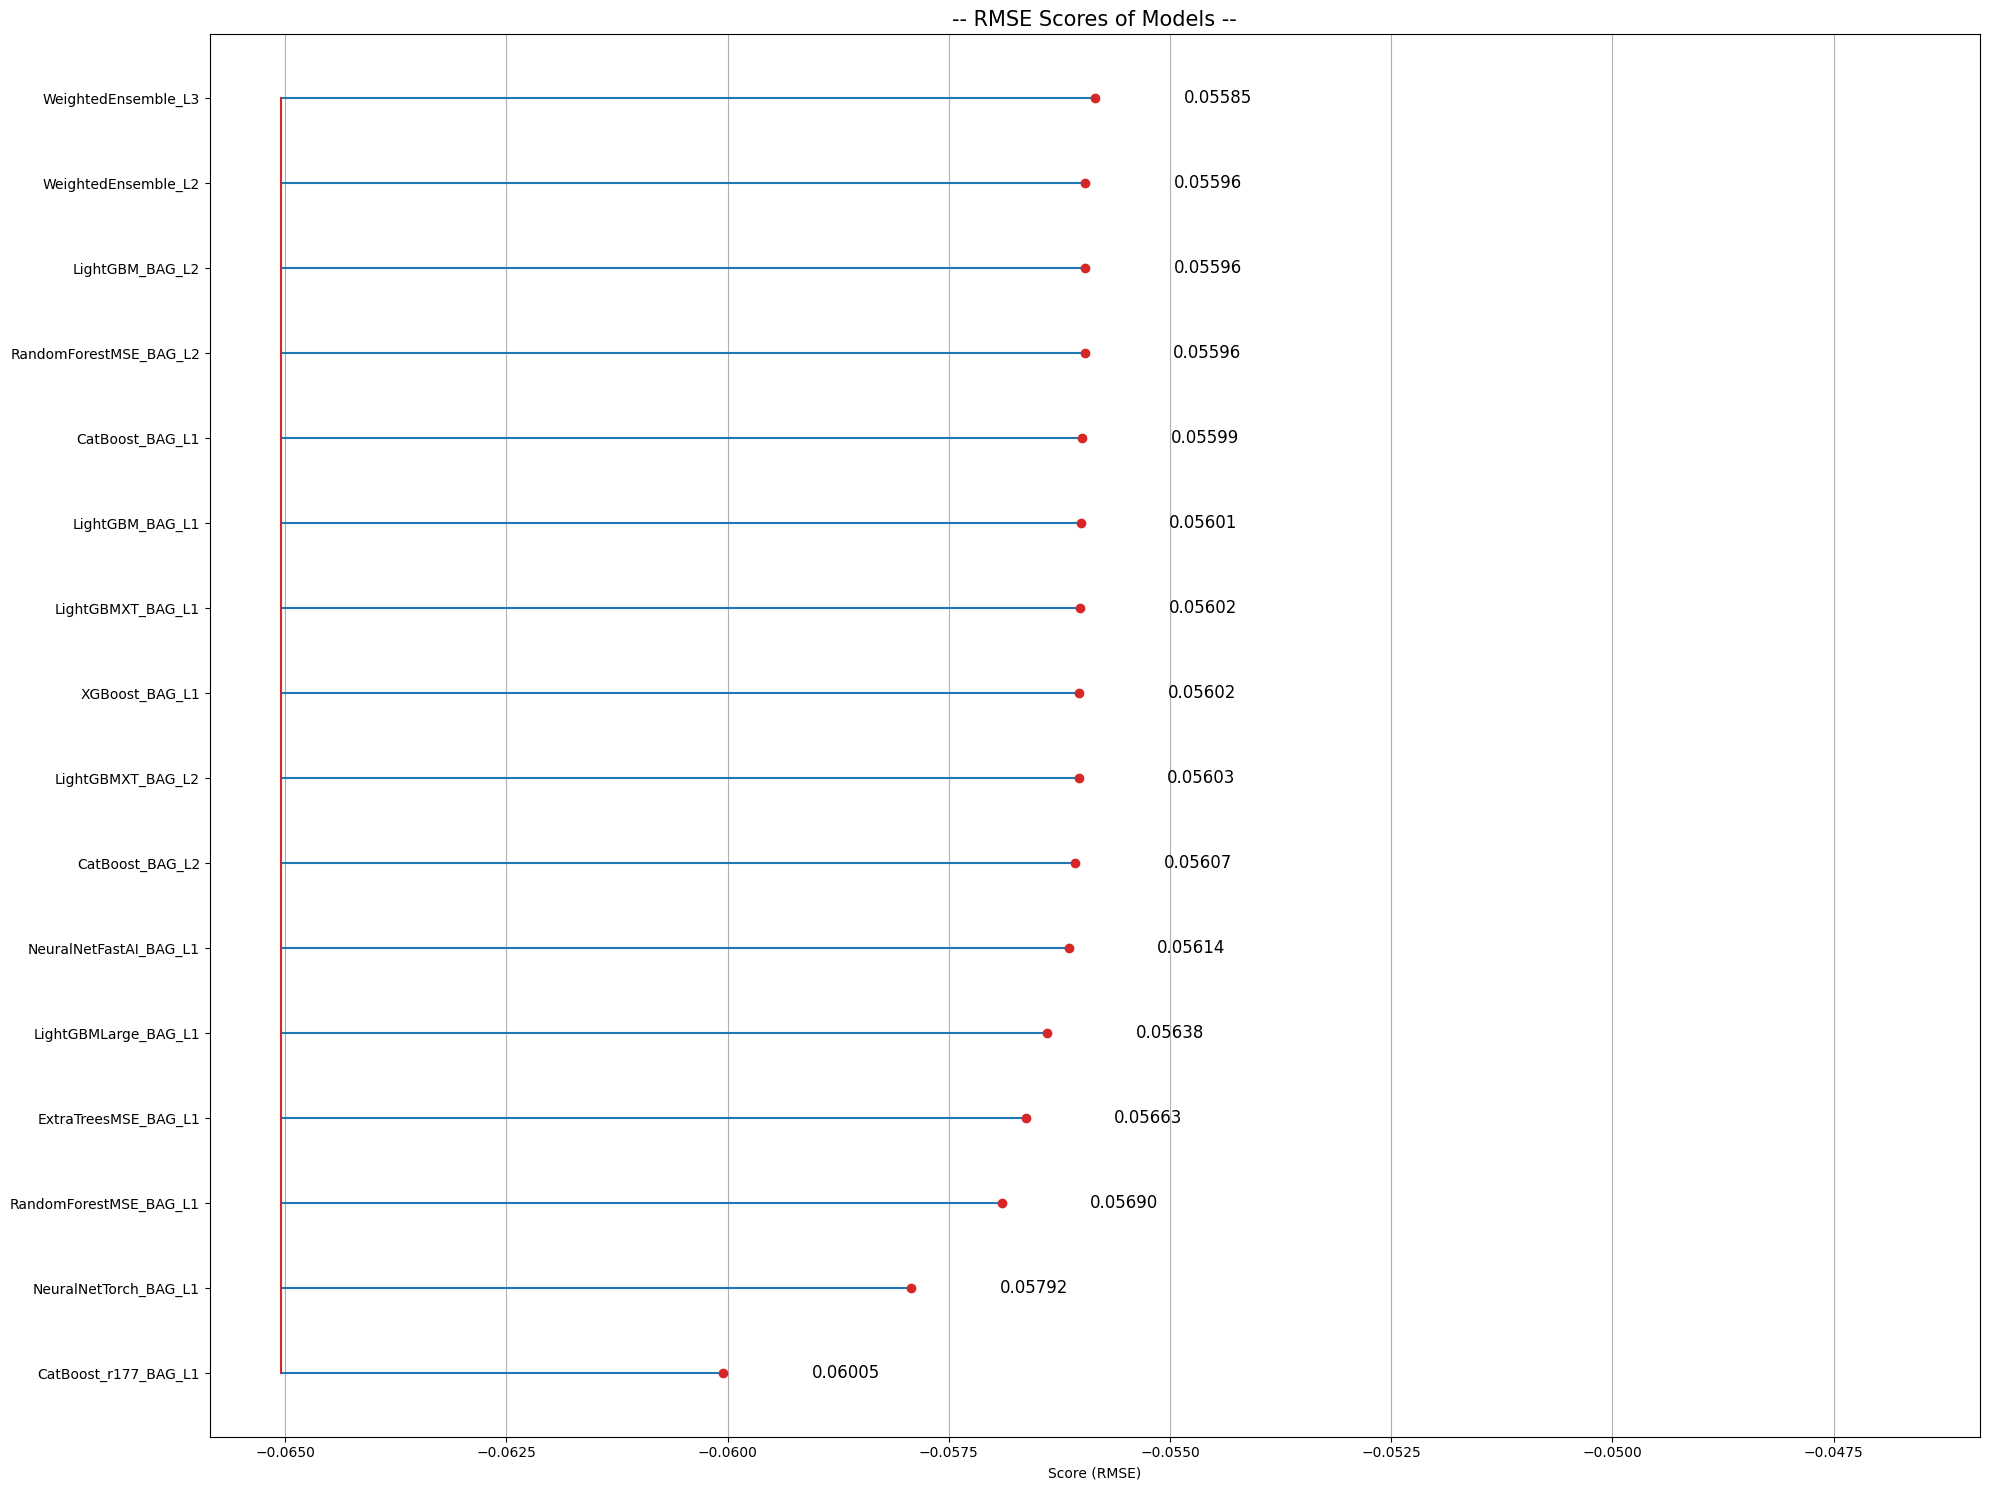

In [23]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(20, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.005,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.0058, max_score + 0.01)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [24]:
predictor.model_names()

['LightGBMXT_BAG_L1',
 'LightGBM_BAG_L1',
 'RandomForestMSE_BAG_L1',
 'CatBoost_BAG_L1',
 'ExtraTreesMSE_BAG_L1',
 'NeuralNetFastAI_BAG_L1',
 'XGBoost_BAG_L1',
 'NeuralNetTorch_BAG_L1',
 'LightGBMLarge_BAG_L1',
 'CatBoost_r177_BAG_L1',
 'WeightedEnsemble_L2',
 'LightGBMXT_BAG_L2',
 'LightGBM_BAG_L2',
 'RandomForestMSE_BAG_L2',
 'CatBoost_BAG_L2',
 'WeightedEnsemble_L3']

In [25]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

In [26]:
# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [27]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_accident_models
!rm -r /kaggle/working/{FOLDER}{NAME_EXT}

In [28]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

